<a href="https://www.kaggle.com/code/ksenia5/resnet50-for-object-detection?scriptVersionId=123222265" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Object detection in images with ResNet50

Use ResNet50, a 50-layer CNN model pretrained on > 40M images

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import random # for shuffling data

# Image tools from scikit image
from skimage import transform, color

import cv2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# import image from keras preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# tensorflow keras applications resnet50
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50, decode_predictions

## Reading in data for transfer learning

Data reshaping with adapted code from this [video tutorial](https://www.youtube.com/watch?v=j-3vuBynnOE).

In [2]:
# Get the object labels
datadir = '/kaggle/input/object-detection'
categories = [f for f in os.listdir('/kaggle/input/object-detection')]
# print(categories)
# print(len(categories))

# list to store labelled image data
all_data = [] 
# dictionary mapping numerical labels to object classes
label_dict = {}

def get_data():
    for cat in categories:
        path = os.path.join(datadir, cat+"/"+cat)
        class_num = categories.index(cat)
        label_dict[class_num] = cat
        for img in os.listdir(path):
            try:
                im = image.load_img(os.path.join(path,img))
                im_shape = np.shape(im)
                im_square = tf.image.resize_with_crop_or_pad(im,target_height=max(im_shape),target_width=max(im_shape))
                im_small = transform.resize(im_square,(224,224),anti_aliasing=False)
                all_data.append([im_small, class_num])
            except Exception as e:
                pass
get_data()

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [3]:
# Check the number of images in each class
for cat in categories:
    num = sum([1 for im, c in all_data if c== categories.index(cat)])
    print(f"{cat}................{num} images")

USB stick................95 images
satellite dish device................95 images
magnifying glass................95 images
laptop................95 images
computer mouse................95 images
keyboard I................26 images
keys objects................95 images
server rack................95 images
phone................95 images
keyboard II................69 images
router................95 images


9 classes each have 95 images, except for the keyboard class which is split into 2 - keyboard I and keyboard II. Together these contain 95 images and represent the same target object (keyboard).
<br>
Create a dictionary mapping numerical class labels to class names.

In [4]:
label_dict = dict([(categories.index(cat),cat) for cat in categories])
label_dict

{0: 'USB stick',
 1: 'satellite dish device',
 2: 'magnifying glass',
 3: 'laptop',
 4: 'computer mouse',
 5: 'keyboard I',
 6: 'keys objects',
 7: 'server rack',
 8: 'phone',
 9: 'keyboard II',
 10: 'router'}

We'll relabel "keyboard I" and "keybord II" as "keyboard" in the dictionary and update the data labels in the all_data array.

In [5]:
label_dict[5] = 'keyboard'
label_dict[9] = 'router'
del label_dict[10]
label_dict

{0: 'USB stick',
 1: 'satellite dish device',
 2: 'magnifying glass',
 3: 'laptop',
 4: 'computer mouse',
 5: 'keyboard',
 6: 'keys objects',
 7: 'server rack',
 8: 'phone',
 9: 'router'}

In [6]:
# data labelled 9 will get label 5
# data labelled 10 will get label 9
data = [[img,5] if label==9 else [img,label] for [img, label] in all_data]
data = [[img,9] if label==10 else [img, label] for [img, label] in data]

In [7]:
# Check the number of images in each class
for label, cat in label_dict.items():
    num = sum([1 for im, c in data if c== int(label)])
    print(f"{label}..{cat}................{num} images")

0..USB stick................95 images
1..satellite dish device................95 images
2..magnifying glass................95 images
3..laptop................95 images
4..computer mouse................95 images
5..keyboard................95 images
6..keys objects................95 images
7..server rack................95 images
8..phone................95 images
9..router................95 images


Now there are 95 images in each of 10 classes.

Next, we'll shuffle the data and split into training and validation sets.

In [8]:
# train test split 
random.shuffle(data)

# for sample in training_data[:10]:
#     print(sample[1])

In [9]:
# Create features nparray and 
X = []
y =[]
for features, label in data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,224,224,3)

In [10]:
# Save data
import pickle
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [11]:
# export labels dictioanry
pickle.dump(label_dict, open("label_dict.pickle", "wb"))
pickle_out.close()

To load data into future notebook use

In [12]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)
pickle_in.close()

label_dict = pickle.load(open("label_dict.pickle","rb"))
pickle_in.close()

In [13]:
print(tf.__version__)

2.11.0


In [14]:
# define function to show image
def show_image(image, title='Image', cmap_type = 'gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

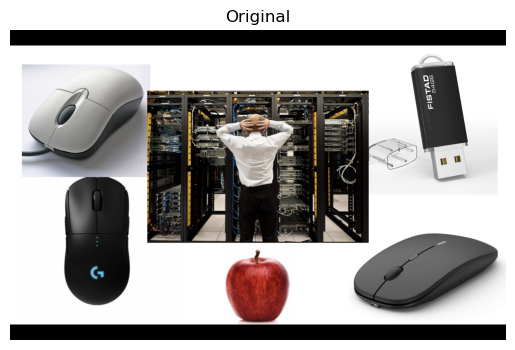

(1800, 2880, 3)
<class 'PIL.Image.Image'>
2880


In [15]:
# load test image
img_path = '/kaggle/input/objectDetection/img.png'
test_image = image.load_img(img_path)
test_shape = np.shape(test_image)
# display image
show_image(test_image, 'Original')
print(test_shape)
print(type(test_image))
print(max(test_shape))



## Image preprocessing

Resizing while maintaining aspect ratio

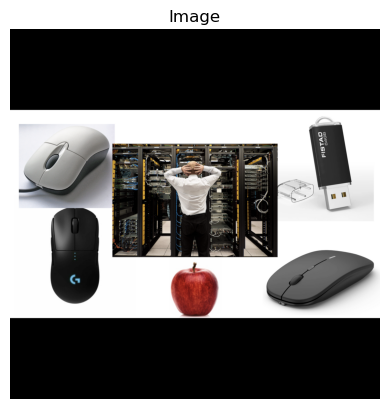

(2880, 2880, 3)


In [16]:
# resizing image to make square
square = tf.image.resize_with_crop_or_pad(test_image,target_height=max(test_shape),target_width=max(test_shape))
show_image(square)
print(square.shape)

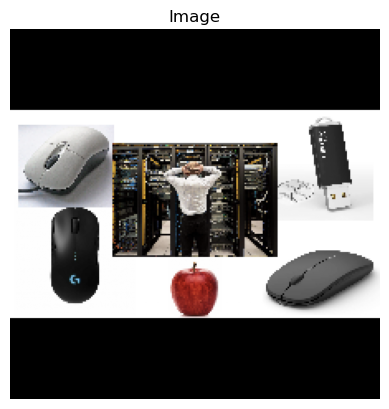

(224, 224, 3)


In [17]:
# scale down image to the right size
small_image = transform.resize(square,(224,224),anti_aliasing=False)
show_image(small_image)
print(small_image.shape)

In [18]:
# # the trained model preprocessing takes care of color conversion
# # otherwise to convert to grayscale

# grayscale = color.rgb2gray(small_image)
# show_image(grayscale, "Grayscale")
# print(grayscale.shape)
# print(type(grayscale))

The next test uses rescaled and padded image, and performs pretty badly with pretrained model

## Make predictions for objects in image
Using pretrained model out of the box


### Using resized and padded images 

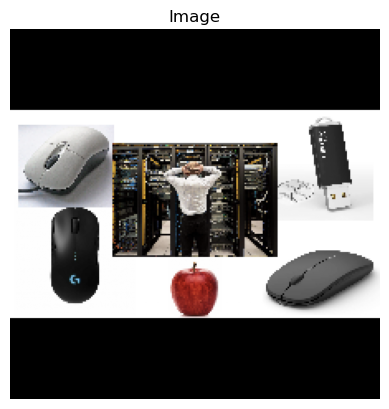

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n03196217', 'digital_clock', 0.09412368), ('n03729826', 'matchstick', 0.076731555), ('n04286575', 'spotlight', 0.03503849), ('n01930112', 'nematode', 0.033637654), ('n06359193', 'web_site', 0.031819727)]


In [19]:
show_image(small_image)
# expand the dimensions so that it's understood by the network:
# img.shape turns from (224,224,3) into (1,224,224,3)
img = np.expand_dims(small_image, axis=0)

# pre-process the img in the same way training images were
img = preprocess_input(img)

# Instantiate a ResNet50 model with imagenet weights
model = ResNet50(weights ='imagenet')

# predict with ResNet50 on our img
preds = model.predict(img)


# Decode predictions and print it
print('Predicted:', decode_predictions(preds)[0])

### Predictions using original image with minimal preprocessing
Next test loads and resizes image without scaling/padding.
<br>

This performs better

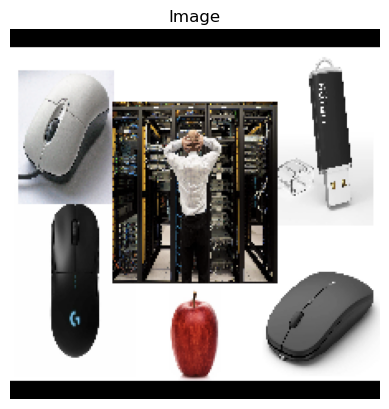

1/1 [==============================] - 1s 1s/step
Predicted: [('n04074963', 'remote_control', 0.2466726), ('n03793489', 'mouse', 0.17965712), ('n04023962', 'punching_bag', 0.1549728), ('n03777754', 'modem', 0.14508493), ('n04208210', 'shovel', 0.04338838)]


In [20]:
# # load the image with the right target size for the model
img = image.load_img(img_path, target_size=(224,224))
show_image(img)
# turn image into array
img = image.img_to_array(img)

# expand the dimensions so that it's understood by the network:
# img.shape turns from (224,224,3) into (1,224,224,3)
img = np.expand_dims(img, axis=0)

# pre-process the img in the same way training images were
img = preprocess_input(img)

# Instantiate a ResNet50 model with imagenet weights
model = ResNet50(weights ='imagenet')

# predict with ResNet50 on our img
preds = model.predict(img)

# Decode predictions and print it
print('Predicted:', decode_predictions(preds)[0])

The pretrained model does better with the second method (no rescaling or padding of image) even thoough the image is distorted (aspect ratio changes) when resized. Maybe because more of the original pixels are preserved?

## Transfer learning

Next, apply tranfer learning to improve pretrained model on our dataset.

<br>

### 1. Load image data

In [21]:
# tensorflow keras models and layers for transfer learning 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Global Variables,number of images/classes to be identified 
NUM_CLASSES = 10
# Calculates average 
RESNET50_POOLING_AVERAGE = 'avg'
# Neural Network layer
DENSE_LAYER_ACTIVATION = 'softmax'

In [22]:

# By using ResNet50 pre-trained weights except its TOP layer, i.e., the xyz_tf_kernels_NOTOP.h5 weights... Use this weights as initial weight for training new layer using train images
resnet_weights_path = 'https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [23]:
model_layers = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model_layers.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 10-class classification
model_layers.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model_layers.layers[0].trainable = False

model_layers.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


## REFERENCES
1. [ResNet50 tutorial from DataCamp](https://campus.datacamp.com/courses/introduction-to-deep-learning-with-keras/advanced-model-architectures?ex=6)
2. https://www.youtube.com/watch?v=j-3vuBynnOE
